In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import re
import glob
import seaborn as sns
from numpy import mean, std
from scipy import stats
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.callbacks import History 
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from sklearn import metrics
from sklearn.metrics import classification_report

!pip install autofeat
from autofeat import FeatureSelector, AutoFeatRegressor, AutoFeatClassifier

In [24]:
# Check for GPU availability
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Load Dataset

Load Dataset, concatenate data and count Rows and Columns

In [25]:
# Download dataset from Github and unzip
!wget 'https://github.com/cargilgar/Smart-Alarm-using-tinyML/raw/main/dataset/datasets.zip'

!unzip datasets.zip

--2021-07-30 17:43:10--  https://github.com/cargilgar/Smart-Alarm-using-tinyML/raw/main/dataset/datasets.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cargilgar/Smart-Alarm-using-tinyML/main/dataset/datasets.zip [following]
--2021-07-30 17:43:10--  https://raw.githubusercontent.com/cargilgar/Smart-Alarm-using-tinyML/main/dataset/datasets.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7952952 (7.6M) [application/zip]
Saving to: ‘datasets.zip.1’

datasets.zip.1      100%[===================>]   7.58M  49.0MB/s    in 0.2s    

2021-07-30 17:43:11 (49.0 MB/s) - ‘datasets.zip.1’ saved 

In [ ]:
# Download RAW dataset from Drive and unzip
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IBJjxb8W2vNKA-SyNZIwC5uovWDk9EmA' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1IBJjxb8W2vNKA-SyNZIwC5uovWDk9EmA" -O RAW_dataset.zip && rm -rf /tmp/cookies.txt
# !unzip RAW_dataset.zip

In [26]:
#Create full dataframe with all subject csv's concatenated
path = r'content/output/'
all_files = glob.glob(path + '/*.csv')

li = []
acc_rows = 0

for filename in all_files:
    subject_csv = pd.read_csv(filename, index_col=False)
    acc_rows += len(subject_csv.axes[0])

    li.append(subject_csv)

df = pd.concat(li, axis=0, ignore_index=True)


#Save big dataframe as CSV
# df.to_csv('all_users_df.csv')

#Rows and Columns
total_rows = len(df.axes[0]) #===> Axes of 0 is for a row
total_cols = len(df.axes[1]) #===> Axes of 1 is for a column
print('Number of Rows: ', total_rows)
print('Number of Columns: ', total_cols)

assert total_rows == acc_rows, 'Number of rows does not match'

df

Number of Rows:  772295
Number of Columns:  6


,Time,X,Y,Z,Heart Rate,Labels
0,1.0,0.745316,2.146820,1.235825,81.0,-1.0
1,2.0,0.651840,1.379974,0.855926,81.0,-1.0
2,3.0,0.757416,1.386505,0.502609,81.0,-1.0
3,4.0,0.763458,1.317490,0.693802,81.0,-1.0
4,5.0,0.753204,1.592545,0.997772,81.0,-1.0
...,...,...,...,...,...,...
772290,28825.0,0.372513,0.498047,0.791885,55.0,5.0
772291,28826.0,0.373016,0.498077,0.791367,55.0,5.0
772292,28827.0,0.373001,0.498047,0.790894,55.0,5.0
772293,28828.0,0.372513,0.497589,0.791870,55.0,5.0


In [27]:
df = df.drop('Time', axis=1)

##EDA

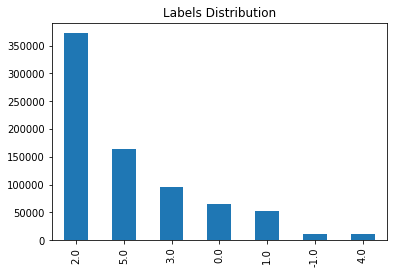

In [ ]:
#Labels Distribution
df['Labels'].value_counts().plot(kind='bar', title ='Labels Distribution')

# Labels
Initial stages (0-5, wake = 0, N1 = 1, N2 = 2, N3 = 3, REM = 5)

Relabeled stages (0-4, wake = 0, N1 = 1, N2 = 2, N3 = 3, REM = 4)

In [28]:
# Delete non-labeled Rows
df.dropna(inplace=True)

df['Labels'] = df['Labels'].astype(int)

df = df.drop(df.index[(df.Labels < 0) | (df.Labels == 4)])

# Same labels will be reused throughout the program
df['Labels'] = df['Labels'].map({0:0,1:1,2:2,3:3,5:4,}, na_action=None)

## Balancing the dataset
Based on the unbalanced distribution of the dataset, let's even it out by applying undersampling (i.e. reducing the number of samples of all of the biggest classes down to the size of the smallest one). 

In the case the resulting dataset is too small, a more advanced approach of combining undersampling and oversampling might be taken. This approach would take a class with the closest size to the average size as a reference threshold, undersample the bigger classes and oversample the smaller ones. this would guarantee a bigger perfeclty balanced dataset.

In [29]:
# Undersampling to the smallest class
from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(df, df["Labels"])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


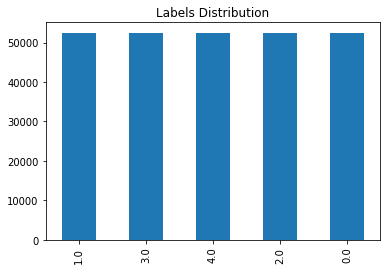

In [30]:
# Building again the dataframe with the balanced X_res reurned from RandomUnderSampler
labels_df = ['X', 'Y', 'Z', 'Heart Rate', 'Labels']
df = pd.DataFrame(X_res, columns=labels_df)

df['Labels'].value_counts().plot(kind='bar',title ='Labels Distribution')

##### Exploring feature's distribution and outliers

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.boxplot(data=df[['X', 'Y', 'Z']], orient='h')
display(ax)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
ax = sns.boxplot(data=df[['Heart Rate']],orient='h')
display(ax)

In [ ]:
sns.pairplot(df[['X', 'Y', 'Z']], kind="scatter", diag_kind= 'kde', height=4)

In [31]:
# Adding derived Features
df['movement_x'] = df['X'] - df['X'].shift()
df['movement_y'] = df['Y'] - df['Y'].shift()
df['movement_z'] = df['Z'] - df['Z'].shift()
df['modulo'] = (df['X']**2 + df['Y']**2 + df['Z']**2)**0.5
df['modulo_movement'] = (df['movement_x']**2 + df['movement_y']**2 + df['movement_z']**2)**0.5

#Other Features
df['X**3'] = df['X'] **3
df['Y**3'] = df['Y'] **3
df['Z**3'] = df['Z'] **3

#Reindex 'Labels Column
labels = df['Labels']
df.drop(['Labels'], axis = 'columns', inplace=True)
df['Labels'] = labels

df

,X,Y,Z,Heart Rate,movement_x,movement_y,movement_z,modulo,modulo_movement,X**3,Y**3,Z**3,Labels
0,0.403351,0.478073,0.794281,54.0,NaN,NaN,NaN,1.011003,NaN,0.065622,0.109265,0.501098,0.0
1,0.065491,0.635971,0.775345,64.0,-0.337860,0.157898,-0.018936,1.004942,0.373416,0.000281,0.257224,0.466106,0.0
2,0.084808,0.025360,1.003128,50.0,0.019318,-0.610611,0.227783,1.007026,0.652000,0.000610,0.000016,1.009414,0.0
3,0.270706,0.571075,0.782044,71.0,0.185898,0.545715,-0.221085,1.005485,0.617448,0.019838,0.186243,0.478292,0.0
4,0.064545,0.635010,0.775879,66.0,-0.206161,0.063934,-0.006165,1.004685,0.215936,0.000269,0.256060,0.467070,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
262290,0.466873,0.047394,0.893829,71.0,0.197250,-0.923798,0.796966,1.009528,1.235907,0.101765,0.000106,0.714108,4.0
262291,0.010712,0.801681,0.603638,72.0,-0.456161,0.754288,-0.290192,1.003587,0.928033,0.000001,0.515235,0.219953,4.0
262292,0.083801,0.097076,0.993133,50.0,0.073090,-0.704605,0.389496,1.001379,0.808404,0.000589,0.000915,0.979542,4.0
262293,0.229446,0.732407,0.646591,60.0,0.145645,0.635330,-0.346542,1.003566,0.738206,0.012079,0.392877,0.270327,4.0


# Autofeat

In [ ]:
#AUTOFEAT
labels = df['Labels']

df_feature = df.drop('Labels', axis=1).fillna(0)
target = labels

for steps in range(2):
    print("### AutoFeat with %i feateng_steps" % steps)
    # afreg = AutoFeatClassifier(verbose=1, feateng_steps=steps)
    afreg = AutoFeatRegressor(verbose=1, feateng_steps=steps)
    df = afreg.fit_transform(df_feature, target)
    r2 = afreg.score(df_feature, target)
    print("## Final R^2: %.4f" % r2)
    
df['Labels'] = labels

# Final processed dataset
df

# Normalize

In [34]:
# Normalizing ALL Features

for feature_name in df.loc[:, df.columns != 'Labels']:
    max_value = df[feature_name].max()
    min_value = df[feature_name].min()
    #df[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    df[feature_name] = df[feature_name] / max_value

    # Round numbers (4 decimals)
    df[feature_name] = df[feature_name].round(4)

df

# Split Dataset
Train, Validation and Test

Split the data
We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons.

It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

***ANOTHER SPLITING OPTION WOULD BE TO SEPARATE USERS (Crear nueva columna con nombre usuario?? O manejar cada CSV por separado??)***





In [36]:
def split_dataset(df, percentage_train, percentage_val, seed=42):

    assert percentage_train + percentage_val < 1, 'Percentage given for splitting not correct'

    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    total_rows = len(df.index)

    train_end = int(percentage_train * total_rows)
    validate_end = int(percentage_val * total_rows) + train_end

    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]

    return train, validate, test

In [37]:
train_df, val_df, test_df = split_dataset(df, 0.7, 0.2)

assert len(train_df) + len(val_df) + len(test_df) == df.shape[0], 'The split does not match'

# Reshape Data into Segments and Prepare for Keras
The data contained in the dataframe is not ready yet to be fed into a neural network. Therefore we need to reshape it. Let’s create another function for this called “create_segments_and_labels”. This function will take in the dataframe and the label names.

In [38]:
def create_segments_and_labels(dataframe):

    labels = dataframe.iloc[:,-1:]
    segments = dataframe.iloc[:,:-1]
    # dataframe.iloc[:,:12]  # from 0 to 12 columns, all the rows

    return segments, labels

In [39]:
# x --> Features
# y --> Labels
   
x_train, y_train = create_segments_and_labels(train_df)
x_val, y_val = create_segments_and_labels(val_df)
x_test, y_test = create_segments_and_labels(test_df)

assert x_train.shape[0] == len(y_train)
assert x_val.shape[0] == len(y_val)
assert x_test.shape[0] == len(y_test)

# Deep Neural Network Model in Keras


In [40]:
# Prepare labels data 
# Needed ONLY for categorical_crossentropy loss function
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)  

In [41]:
# define the keras model
num_classes = 5

model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax')) # The last layer corresponds with the number of possible outputs

# compile the keras model
# opt = SGD(learning_rate=0.01, momentum=0.9)

# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                832       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 325       
Total params: 9,477
Trainable params: 9,477
Non-trainable params: 0
_________________________________________________________________


Train Model

In [42]:
# fit the keras model on the dataset
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=150, batch_size=180, verbose=1)

Epoch 1/150
1021/1021 [==============================] - 4s 3ms/step - loss: nan - accuracy: 0.3707 - val_loss: nan - val_accuracy: 0.2002
Epoch 2/150
1021/1021 [==============================] - 3s 3ms/step - loss: nan - accuracy: 0.1993 - val_loss: nan - val_accuracy: 0.2002
Epoch 3/150
1021/1021 [==============================] - 3s 3ms/step - loss: nan - accuracy: 0.1979 - val_loss: nan - val_accuracy: 0.2002
Epoch 4/150
1021/1021 [==============================] - 3s 3ms/step - loss: nan - accuracy: 0.2001 - val_loss: nan - val_accuracy: 0.2002
Epoch 5/150
1021/1021 [==============================] - 3s 3ms/step - loss: nan - accuracy: 0.2004 - val_loss: nan - val_accuracy: 0.2002
Epoch 6/150
1021/1021 [==============================] - 3s 3ms/step - loss: nan - accuracy: 0.1993 - val_loss: nan - val_accuracy: 0.2002
Epoch 7/150
1021/1021 [==============================] - 3s 3ms/step - loss: nan - accuracy: 0.2016 - val_loss: nan - val_accuracy: 0.2002
Epoch 8/150
1021/1021 [====

KeyboardInterrupt: ignored

# Evaluate Model on Test Data

In [ ]:
# evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

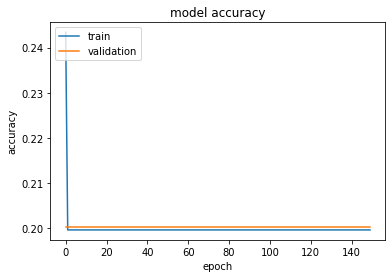

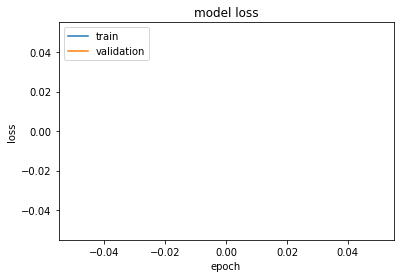

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Confusion Matrix

In [ ]:
predictions = history.model.predict(x_test)

In [ ]:
guess = 0

to_predict = len(y_test)

for index in range(to_predict):
    if np.argmax(predictions[index]) == np.argmax(y_test[index]):
        guess += 1

# np.argmax(predictions[index]), np.argmax(y_test[index])
print("Guessed: {:.2f}%".format(guess/to_predict*100))

In [ ]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                #xticklabels=LABELS,
                #yticklabels='0','1','2',
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

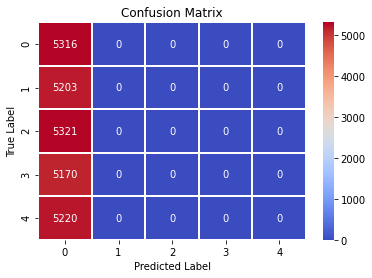

              precision    recall  f1-score   support

           0       0.20      1.00      0.34      5316
           1       0.00      0.00      0.00      5203
           2       0.00      0.00      0.00      5321
           3       0.00      0.00      0.00      5170
           4       0.00      0.00      0.00      5220

    accuracy                           0.20     26230
   macro avg       0.04      0.20      0.07     26230
weighted avg       0.04      0.20      0.07     26230



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

# Predictions

In [ ]:
# test the trained model with the full x_test
predictions = model.predict(x_test)

In [ ]:
predictions[0], y_test[0]

In [ ]:
predictions[500], y_test[500]

In [ ]:
predictions[800], y_test[800]

In [ ]:
predictions[1200], y_test[1200]

In [ ]:
predictions[2000], y_test[2000] # bad prediction

In [ ]:
predictions[2400], y_test[2400]

In [ ]:
for i in range(2000):
    predictions[i]